In [1]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
from scipy import optimize

In [2]:
#from Laher & Gilmore (1991)
states_N2 = ["N2(X1Sigmag+)","N2(A3Sigmau+)","N2(B3Pig)","N2(W3Deltau)","N2(Bp3Sigmau-)",
             "N2(ap1Sigmau-)","N2(a1Pig)","N2(w1Deltau)","N2(C3Piu)","N2(E3Sigmag+)","N2(D3Sigmau+)"]
states_N2p = ["N2+(X2Sigmag+)","N2+(A2Piu)","N2+(B2Sigmau+)","N2+(C2Sigmau+)"]

vib_constants_N2 = [[0.0, 2358.57, 14.324, -2.26E-3, -2.4E-4, 0],
                    [49754.8, 1460.48, 13.775, -1.175E-2, 1.41E-4, -7.29E-5],
                    [59306.8, 1734.38, 14.558, 1.40E-2, -1.13E-3, 0],
                    [59380.2, 1506.53, 12.575, 3.09E-2, -7.1E-4, 0],
                    [65851.3, 1516.88, 12.181, 4.19E-2, -7.3E-4, 0],
                    [67739.3, 1530.25, 12.075, 4.13E-2, -2.9E-4, 0],
                    [68951.2, 1694.21, 13.949, 7.94E-3, 2.9E-4, 0],
                    [71698.4, 1559.50, 12.008, 4.54E-2, 0, 0],
                    [88977.9, 2047.18, 28.445, 2.0883, -5.350E-1, 0],
                    [95774.5, 2218, 16.3, -2.7E-2, -2.6E-3, 0],
                    [103570.9, 2207, 16.3, -2.7E-2, -2.6E-3, 0]]

vib_constants_N2p = [[125667.5, 2207.37, 16.302, -2.67E-3, -2.61E-3, 3.7E-5],
                     [134683.1, 1903.51, 15.029, 2.03E-3, 0, 0],
                     [151233.5, 2420.83, 23.851, -0.3587, -6.192E-2, 0],
                     [190209.5, 2071.5, 9.29, -0.43, 0, 0]]

rot_constants_N2 = [[1.99824, 1.7318E-2, -3.3E-5, 0, 0],
                    [1.45499, 1.8385E-2, 1.24E-5, -6.7E-6, 0],
                    [1.63802, 1.8302E-2, -8.4E-6, -3.4E-6, 0],
                    [1.47021, 1.6997E-2, -1.01E-5, 3.3E-7, 0],
                    [1.4731, 1.668E-2, 1.84E-5, -4.5E-7, 0],
                    [1.4799, 1.657E-2, 2.41E-5, 0, 0],
                    [1.6169, 1.793E-2, -2.93E-5, 0, 0],
                    [1.4963, 1.63E-2, 0, 0, 0],
                    [1.8247, 1.868E-2, -2.28E-3, 7.33E-4, -1.5E-4],
                    [1.9368, 1.90E-2, -1.9E-4, 0, 0],
                    [1.9705, 1.90E-2, -1.9E-4, 0, 0]]

rot_constants_N2p = [[1.93177, 1.900E-2, -1.91E-5, -5.00E-6, 4.6E-8],
                     [1.7442, 1.838E-2, -1.76E-4, 4.4E-6, 0],
                     [2.0845, 2.132E-2, -8.5E-4, 0, 0],
                     [1.5114, 1.10E-3, -8.2E-4, 0, 0]]

In [3]:
mu=1.16294E-26 # N2 reduced mass
wavenumber_per_eV = 8065.6

In [4]:
def Gv(v, we, wexe, weye, weze=0, weae=0):
    "Vibrational energy level"
    return we*(v+1/2) - wexe*(v+1/2)**2 + weye*(v+1/2)**3 + weze*(v+1/2)**4 + weae*(v+1/2)**5

def Te(v, T0, we, wexe, weye, weze=0, weae=0):
    "Energy at minimum of well"
    return T0 - we/2 + wexe/4 - weye/8 - weze/16 - weae/32

def Tv(v, T0, we, wexe, weye, weze=0, weae=0):
    "Energy difference from minimum to vibrational energy level"
    return Te(v, T0, we, wexe, weye, weze, weae) + Gv(v, we, wexe, weye, weze, weae)

def Bv(v, Be, ae, ge=0, de=0, ee=0):
    "Rotational energy level"
    return Be - ae*(v+1/2) - ge*(v+1/2)**2 + de*(v+1/2)**3 + ee*(v+1/2)**4

def fIntegrand(vp, v, vibConstants):
    "Integrand of Gilmore et al (1992) eqn 1"
    (T0, we, wexe, weye, weze, weae) = vibConstants
    return 1/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

def gIntegrand(vp, v, vibConstants, rotConstants):
    "Integrand of Gilmore et al (1992) eqn 2"
    (T0, we, wexe, weye, weze, weae) = vibConstants
    (Be, ae, ge, de, ee) = rotConstants
    return Bv(v,Be,ae,ge)/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

In [5]:
def f(v, vibConstants):
    "Gilmore et al (1992) eqn 1"
    I = quad(fIntegrand,-1/2,v,args=(v, vibConstants), full_output=True, epsabs=1.0E-16, limit=24)
    return 1/(2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck)) * I[0] * 1E8

def g(v, vibConstants, rotConstants):
    "Gilmore et al (1992) eqn 2"
    I = quad(gIntegrand,-1/2,v,args=(v, vibConstants, rotConstants), epsabs=1.0E-16, limit=24)
    return 2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck) * I[0] * 1E-8

In [6]:
def r(v, vibConstants, rotConstants):
    "Compute r_inner and r_outer from Gilmore et al (1992) eqn 3"
    fv=f(v, vibConstants)
    gv=g(v, vibConstants, rotConstants)
    return [math.sqrt(fv**2 + fv/gv)-fv, math.sqrt(fv**2 + fv/gv)+fv]

In [7]:
def compute_pes(state, vib_constants, rot_constants, vmax=3):
    """compute vmax*2 points on a potential energy surface defined by
    vibrational constants (vib_constants) and rotational constants (rot_constants)
    for state 'state'
    
    Arguments
    ---------
    state : int
        the array index of the vib_contants and rot_contants arrays indicating
        which state is to be computed
        
    vib_/rot_constants : list
        list of vibrational and rotational constants from constants.py
        
    vmax : int
        max vibrational mode of interest; vmax * 2 points will be calculated
        (r_inner's and r_outer's)
        
    Returns
    -------
    pes : numpy.array
        points on the PES (r, Tv)
    """
    pes = []
    
    (T0, we, wexe, weye, weze, weae) = vib_constants[state]
    
    for vp in range(vmax+1):
        rvp=r(vp, vib_constants[state], rot_constants[state])
        Tvp=Tv(vp, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        pes.insert(0, [rvp[0], Tvp])
        pes.append([rvp[1], Tvp])
    
    pes = np.asarray(pes)
                
    return pes

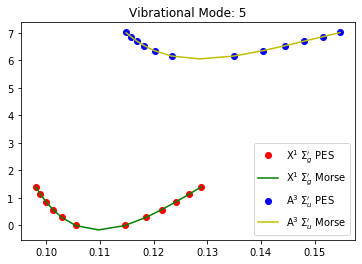

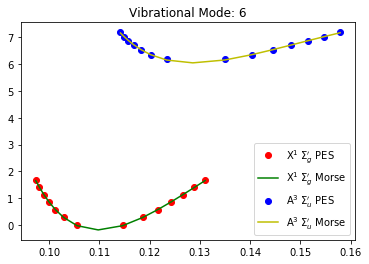

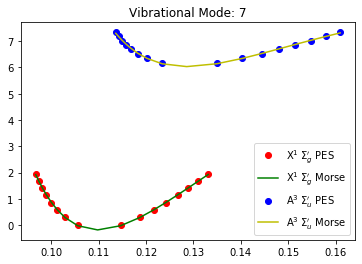

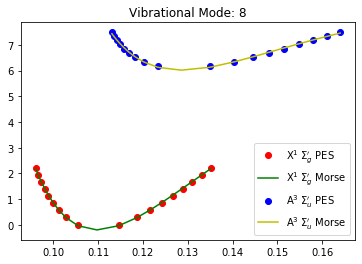

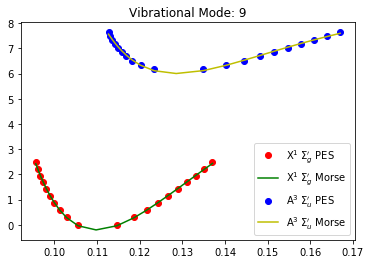

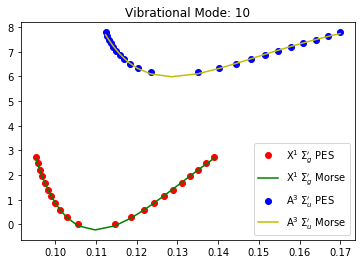

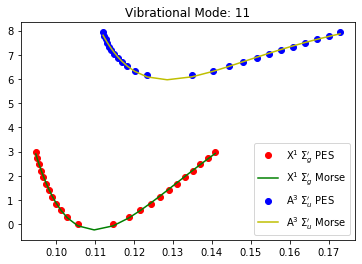

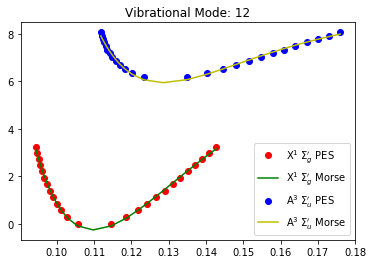

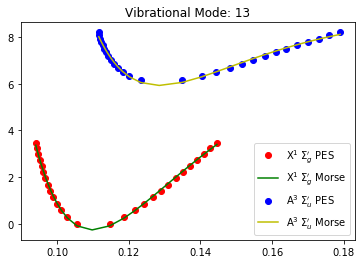

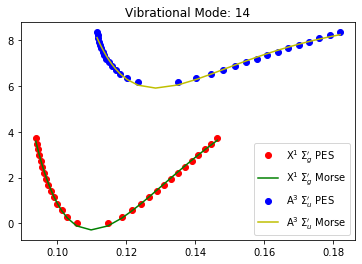

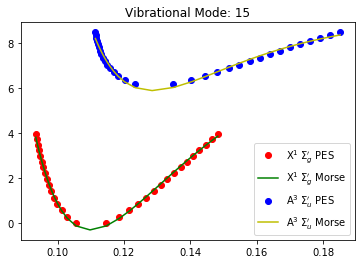

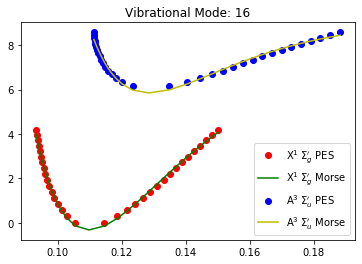

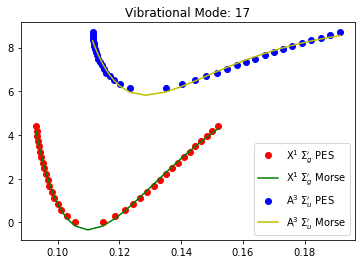

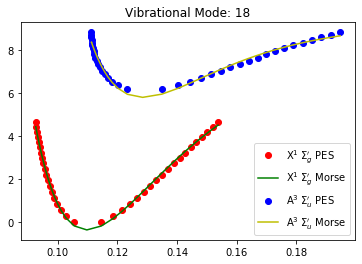

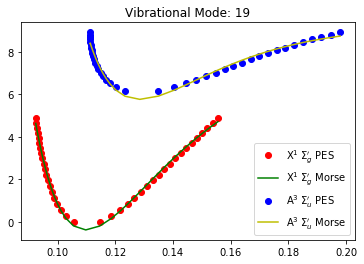

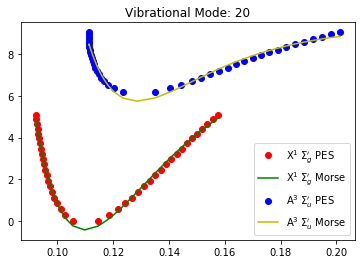

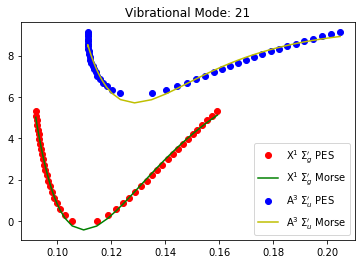

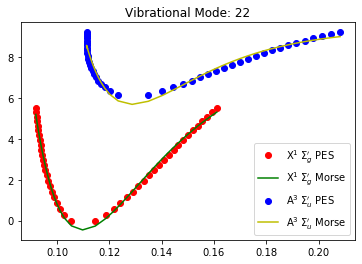

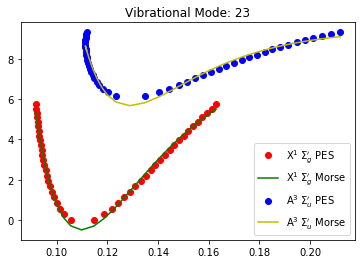

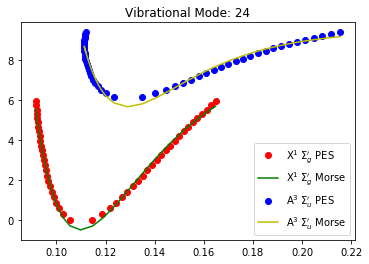

In [8]:
# the number of vibrational modes
vibrational_mode = np.arange(5, 25)

# dictionary for the mean square errors of the different vibrational modes
msqe_X1Sigmagp = {}
msqe_A3Sigmaup = {}

# dictionary for the constants we'll get from the fit
fit_constants_X1 = {}
fit_constants_A3 = {}

for i in vibrational_mode:
    
    X1Sigmagp_pes = compute_pes(0, vib_constants_N2, rot_constants_N2, vmax=i)
    A3Sigmaup_pes = compute_pes(1, vib_constants_N2, rot_constants_N2, vmax=i)

    # optimize has a hard time doing the fit with a square in the function. You have to decompose it. 
    # Also, you have to give it a constant (p[2]) for the minimum energy when r=r_e.

    fitfunc = lambda p, x: p[0] * (1.0 - np.exp(-p[1] * (x - p[2]))) * (1.0 - np.exp(-p[1] * (x - p[2]))) + p[3] # Target function
    errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function

    # p[0]=De, p[1]=Beta, p[2]=re, p[3]=D0 
    p0_0 = [10.0, 0.001, 0.11, -1.0] # Initial guess for the parameters
    p0_1, success0 = optimize.leastsq(errfunc, p0_0[:], args=(X1Sigmagp_pes[:,0], X1Sigmagp_pes[:,1]))

    # p[0]=De, p[1]=Beta, p[2]=re, p[3]=D0 
    p1_0 = [10.0, .001, 0.13, 6.0] # Initial guess for the parameters
    p1_1, success1 = optimize.leastsq(errfunc, p1_0[:], args=(A3Sigmaup_pes[:,0], A3Sigmaup_pes[:,1]))
    
    # constants taken from the fit: De, Beta, re, D0
    fit_constants_X1[i] = [p0_1[0], p0_1[1], p0_1[2], p0_1[3]]
    fit_constants_A3[i] = [p0_1[0], p0_1[1], p0_1[2], p0_1[3]]
    
    # Plotting the functions
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    x,y = X1Sigmagp_pes.T
    x_fit_X1 = np.insert(x, i+1, p0_1[2])
    y_fit_X1_nore = fitfunc(p0_1, x)
    y_fit_X1 = fitfunc(p0_1, x_fit_X1)

    #ax1.scatter(x, y, s=10, c='b', marker="s", label='X${}^1\;\Sigma_g^\prime$')
    plt.plot(x, y, "ro", label = 'X${}^1\;\Sigma_g^\prime$ PES')
    plt.plot(x_fit_X1, y_fit_X1, "g-", label = 'X${}^1\;\Sigma_g^\prime$ Morse') # Plot of the data and the fit

    # making the A3Sigmaup easier to graph
    x,y = A3Sigmaup_pes.T
    x_fit_A3 = np.insert(x, i+1, p1_1[2])
    y_fit_A3_nore = fitfunc(p1_1, x) # the fit function without the re value so that we can do the msqe
    y_fit_A3 = fitfunc(p1_1, x_fit_A3)

    #ax1.scatter(x,y, s=10, c='r', marker="o", label='A${}^3\;\Sigma_u^\prime$')
    plt.plot(x, y, "bo", label = 'A${}^3\;\Sigma_u^\prime$ PES')
    plt.plot(x_fit_A3, y_fit_A3, "y-", label = 'A${}^3\;\Sigma_u^\prime$ Morse') # Plot of the data and the fit
    plt.title('Vibrational Mode: %s' % i)
    plt.legend(loc='lower right');
    plt.show()

    # calculating the mean square error of between the PES and the fit 
    msqe_X1Sigmagp_cal = (np.square(X1Sigmagp_pes.T[1] - y_fit_X1_nore)).mean()
    msqe_X1Sigmagp[i] = msqe_X1Sigmagp_cal

    # calculating the mean square error of between the PES and the fit
    msqe_A3Sigmaup_cal = (np.square(A3Sigmaup_pes.T[1] - y_fit_A3_nore)).mean()
    msqe_A3Sigmaup[i] = msqe_A3Sigmaup_cal
    

In [9]:
#ii = 5
#while ii < 24:
    #print(fit_constants_X1[ii][0])
    #ii += 1

In [11]:
msqe_A3Sigmaup

{5: 0.00011644150807377381,
 6: 0.00023485053497046708,
 7: 0.00043015569625715663,
 8: 0.0007342645396476597,
 9: 0.0011875478976047815,
 10: 0.0018403948951895945,
 11: 0.0027550052748877792,
 12: 0.004007434436075036,
 13: 0.0056898928863033564,
 14: 0.007913276279245892,
 15: 0.01080985844368803,
 16: 0.014536008735461724,
 17: 0.01927468529155753,
 18: 0.025237294784243646,
 19: 0.03266428737307446,
 20: 0.041823575066309425,
 21: 0.05300555334738002,
 22: 0.06651325347513064,
 23: 0.08264611821686979,
 24: 0.10167632192412951}

In [12]:
msqe_X1Sigmagp

{5: 8.356430263226604e-05,
 6: 0.00016150659390765554,
 7: 0.0002831130715414661,
 8: 0.00046191615896353823,
 9: 0.0007131324104660522,
 10: 0.0010535680852500012,
 11: 0.0015014962407365173,
 12: 0.0020765020199943235,
 13: 0.002799292689429738,
 14: 0.0036914689195859367,
 15: 0.004775253809641903,
 16: 0.006073176263833559,
 17: 0.007607705548223897,
 18: 0.009400834233858702,
 19: 0.011473607293396052,
 20: 0.013845595899363966,
 21: 0.016534315533093112,
 22: 0.019554589411636607,
 23: 0.022917859974809874,
 24: 0.026631453498597378}

This is a great start. Very impressive. Looks like there's no rule of thumb for how high we can extend the fit for <5% MSQE (v_max = 20 for A3Sigmaup, but we could go even higher for X1Sigmagp). We need to determine the v_max that results in MSQE < 5% for each state of N$_2$ and N$_2^+$.  

Please refactor the above code to be able to loop through all of states of N$_2$ and N$_2^+$ to collect the fit parameters and MSQE for each `v_max` for each state.

I like your use of a dictionary. Let's extend that a bit. In the end I think we want a list of dictionaries, where each dictionary has the following key:value pairs:

"name" : short name for state (e.g. "X1Sigmagp")
"v_max" : max v used for constructing the PES and fitting Morse potential
"p" : fit parameters for Morse potential
"MSQE" : mean square error for fit

In the loop, you can start a list and then add a dictionary to the list with something like this:

`
PES_fits = []
for i in N2_states:
    "code to get fit parameters and MSQE; you'll want to start with v_max = 5 and stop when MSQE > 0.05"
    PES_fits.append({"name": N2_states[i],
                     "v_max": v_max,
                     "p": p,
                     "MSQE": msqe})
`
                     
Then, analyze your results and make a LaTeX table of highest `v_max` that is <5% MSQE, the MSQE, and fit parameters for each state.

Finally, I'd love to have all of the PES's and fits on one plot (for highest `v_max` that has MSQE < 5%).